# Generate SIFT feature vectors for defect classification

This notebook generates feature vectors to be used for clustering local patterns in Rayleigh-Benard Convection. We run the SIFT-like algorithm for the topological and persistent homology keypoints to generate feature vectors at each keypoint.

In [1]:
import numpy as np
import scipy
from scipy.cluster import hierarchy as hc
import pandas as pd
from skimage import morphology
from scipy import misc
from matplotlib import pyplot as plt
import math, time
from skimage import measure
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn.apionly as sns 
from scipy import spatial
import time

%matplotlib inline  

## Set up local environment variables

In [13]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast'
sBmp = 'g21flow/bmps/%06d.bmp'
sOrientation = 'g21flow/orientation_field_3/%06d.bmp'
sSingularPoints = 'g21flow/singular_points_3/%06d.txt'
sSubPD = 'g21flow/pd_sub/%06d.csv'
sSupPD = 'g21flow/pd_sup/%06d.csv'

sFeatureVectors = 'g21flow/feature_vectors_test_2/%06d.txt'

roll_width = 30 # Width of a single roll
centerx = 210 # Center-x of circular crop
centery = 210 # Center-y of circular crop
crop_radius = 210-roll_width # Radius of circular crop

delta = 10
lowercutoff = 45
uppercutoff = 200


## Utility functions

In [6]:
def loadData(idx):
    # Get orientation field
    of = misc.imread(sDir + "/" + (sOrientation % idx))
    
    bmp = misc.imread(sDir + "/" + (sBmp % idx))
    
    # Persistent homology lower saddle points
    ph_features_sub = pd.read_csv(sDir + "/" + (sSubPD % idx))
    ph_features_sub = pd.DataFrame(ph_features_sub)
    
    # Persistent homology upper saddle points
    ph_features_sup = pd.read_csv(sDir + "/" + (sSupPD % idx))
    ph_features_sup = pd.DataFrame(ph_features_sup)

    # Generate persistent homology defect matrix
    ph_lower_saddles = ph_features_sub.loc[(ph_features_sub['dim']==0) & ((ph_features_sub['death'] - ph_features_sub['birth']) >= delta) & (ph_features_sub['death']>=lowercutoff) & (ph_features_sub['death']<=127)][['d_x','d_y']]
    ph_lower_saddles.columns = ['x', 'y']
    ph_tmp = ph_features_sub.loc[(ph_features_sub['dim']==1) & ((ph_features_sub['death'] - ph_features_sub['birth']) >= delta) & (ph_features_sub['birth']>=lowercutoff) & (ph_features_sub['birth']<=127)][['b_x','b_y']]
    ph_tmp.columns = ['x', 'y']
    ph_lower_saddles = pd.concat([ph_lower_saddles, ph_tmp])
    ph_lower_saddles['ph_sub_0'] = 1
    ph_lower_saddles['ph_sub_1'] = 0
    ph_lower_saddles['ph_sup_0'] = 0
    ph_lower_saddles['ph_sup_1'] = 0
    ph_lower_saddles['td_p1'] = 0
    ph_lower_saddles['td_m1'] = 0
    ph_lower_saddles['td_p2'] = 0
    ph_lower_saddles['td_m2'] = 0
    
    ph_upper_saddles = ph_features_sup.loc[(ph_features_sup['dim']==0) & ((ph_features_sup['birth'] - ph_features_sup['death']) >= delta) & (ph_features_sup['death']>=127) & (ph_features_sup['death']<=uppercutoff)][['d_x','d_y']]
    ph_upper_saddles.columns = ['x', 'y']
    ph_tmp = ph_features_sup.loc[(ph_features_sup['dim']==1) & ((ph_features_sup['birth'] - ph_features_sup['death']) >= delta) & (ph_features_sup['birth']>=127) & (ph_features_sup['birth']<=uppercutoff)][['b_x','b_y']]
    ph_tmp.columns = ['x', 'y']
    ph_upper_saddles = pd.concat([ph_lower_saddles, ph_tmp])
    ph_upper_saddles['ph_sub_0'] = 0
    ph_upper_saddles['ph_sub_1'] = 0
    ph_upper_saddles['ph_sup_0'] = 1
    ph_upper_saddles['ph_sup_1'] = 0
    ph_upper_saddles['td_p1'] = 0
    ph_upper_saddles['td_m1'] = 0
    ph_upper_saddles['td_p2'] = 0
    ph_upper_saddles['td_m2'] = 0
    
    ph_lower_plumes = ph_features_sub.loc[(ph_features_sub['dim']==1) & ((ph_features_sub['death'] - ph_features_sub['birth']) >= delta) & (ph_features_sub['birth']<=127) & (ph_features_sub['death']<=uppercutoff)][['d_x','d_y']]
    ph_lower_plumes.columns = ['x', 'y']
    ph_lower_plumes['ph_sub_0'] = 0
    ph_lower_plumes['ph_sub_1'] = 1
    ph_lower_plumes['ph_sup_0'] = 0
    ph_lower_plumes['ph_sup_1'] = 0
    ph_lower_plumes['td_p1'] = 0
    ph_lower_plumes['td_m1'] = 0
    ph_lower_plumes['td_p2'] = 0
    ph_lower_plumes['td_m2'] = 0
    
    ph_upper_plumes = ph_features_sup.loc[(ph_features_sup['dim']==1) & ((ph_features_sup['birth'] - ph_features_sup['death']) >= delta) & (ph_features_sup['birth']>=127) & (ph_features_sup['death']>=lowercutoff)][['d_x','d_y']]
    ph_upper_plumes.columns = ['x', 'y']
    ph_upper_plumes['ph_sub_0'] = 0
    ph_upper_plumes['ph_sub_1'] = 0
    ph_upper_plumes['ph_sup_0'] = 0
    ph_upper_plumes['ph_sup_1'] = 1
    ph_upper_plumes['td_p1'] = 0
    ph_upper_plumes['td_m1'] = 0
    ph_upper_plumes['td_p2'] = 0
    ph_upper_plumes['td_m2'] = 0

    ph_defects = np.concatenate((ph_lower_saddles, ph_upper_saddles, ph_lower_plumes, ph_upper_plumes), axis=0)

    # Topological defects
    td = pd.read_csv(sDir + "/" + (sSingularPoints % idx), sep=' ', names=['y', 'x', 'type'])
    td_defects = td.astype(np.int)
    td_defects['ph_sub_0'] = 0
    td_defects['ph_sub_1'] = 0
    td_defects['ph_sup_0'] = 0
    td_defects['ph_sup_1'] = 0
    td_defects['td_p1'] = (td_defects['type'] == 1).astype(np.int)
    td_defects['td_m1'] = (td_defects['type'] == -1).astype(np.int)
    td_defects['td_p2'] = (td_defects['type'] == 2).astype(np.int)
    td_defects['td_m2'] = (td_defects['type'] == -2).astype(np.int)
    
    td_defects = td_defects.drop('type', 1)
    td_defects = td_defects[['x', 'y', 'ph_sub_0', 'ph_sub_1', 'ph_sup_0', 'ph_sup_1', 'td_p1', 'td_m1', 'td_p2', 'td_m2']]

    return (of, np.concatenate((ph_defects, td_defects), axis=0), bmp)


In [7]:
def loadData_Lyap(idx):
    # Get orientation field
    of = misc.imread(sDir + "/" + (sOrientation % idx))
    # Get bitmap image
    bmp = misc.imread(sDir + "/" + (sBmp % idx))
    # Get Lyapunov local maxima (from H1 sublevel death critical cell)
    lyap_gens = pd.read_csv(sDir + "/" + (sLyapunovSupPD % idx))
    lyap_gens = lyap_gens.loc[(lyap_gens['dim']==1) & (lyap_gens['death']>=lyap_threshold)]
    lyap_gens = lyap_gens[['d_x', 'd_y','death']]
    
    lyap_gens = np.asarray(lyap_gens)

    return (of, lyap_gens, bmp)


In [8]:
def convertMainOrientationBin(_bin, _nbins):
    # Convert from [0,_nbins] to [0,180] to [0,pi]
    orientation = math.radians(_bin*180*(1/_nbins))
    # Convert from [0,pi] to [-pi/2, pi/2]
    orientation = orientation - math.pi/2.
    # Convert from [-pi/2, pi/2] to [pi/2 -> -pi/2 decreasing]
    orientation = orientation*-1.
    
    return orientation
    

In [22]:
def assignOrientations(_keypoints, _radius, _orientationfield, nbins, max_factor, _bmp, makeplot):
    """
    Takes in the list of keypoints, the orientation field, and the number of binning values to
    use for the orientation field. Generates a histogram of orientations. Computes the max peak.
    Assigns corresponding orientation to the original keypoint. Adds copies of keypoint to the
    table with orientations given by other peaks that are at least 80% of max peak.
    """
    
    plt.rcParams['figure.figsize'] = (10.0, 5.0)
    
    allKeypoints = _keypoints
    allKeypoints = np.hstack([allKeypoints, np.zeros((_keypoints.shape[0],2), np.int)])
        
    # Get circular crop
    crop = np.zeros((_radius*2, _radius*2))
    crop[_radius, _radius] = 1
    crop = morphology.binary_dilation(crop, morphology.disk(_radius))
    
    for i in range(_keypoints.shape[0]):
                
        x = _keypoints[i,0]
        y = _keypoints[i,1]
        
        if (((x - centerx)**2 + (y - centery)**2) <= crop_radius**2):

            # Crop orientation field
            cropped_orientation = _orientationfield[(y-_radius):(y+_radius), (x-_radius):(x+_radius)]
            
            # Get histogram for the orientation field
            orig_hist = np.histogram(cropped_orientation[crop==1], bins=nbins, range=(0,256))[0]
            hist = scipy.ndimage.filters.gaussian_filter(orig_hist, sigma=0.75)
            maxpeak = max(hist)
        
            
            if makeplot:
                plt.subplot(1,2,1)
                plt.plot(orig_hist)
                plt.plot(hist)
                plt.plot([0,nbins], [maxpeak*max_factor, maxpeak*max_factor])
                plt.plot([0,nbins], [max(orig_hist)*max_factor, max(orig_hist)*max_factor])

            peaks = (hist >= max_factor*float(maxpeak)).astype(np.int)

            # Label each of the peak components
            peak_components = measure.label(peaks, background=0)+1
            
            
            if (x==153) & (y==320):
                print peak_components

                        
            # If peak wraps first bin to last bin, combine these peaks
            if (peak_components[0] > 0) & (peak_components[-1] > 0):
                peak_components[(peak_components == peak_components[-1])] = peak_components[0]

            maxorientations = []

            for peak_ind in range(1,max(peak_components)+1):
                # Extract the histogram values that fall on this component
                peak_values = np.multiply((peak_components == peak_ind).astype(int), hist)
                maxorientations.append([np.argmax(peak_values), sum(peak_values)])

            maxorientations = np.asarray(maxorientations)
            
            if (x==153) & (y==320):
                print maxorientations
            
            if makeplot:
                plt.subplot(1,2,2)
                plt.imshow(bmp[(y - radius):(y + radius), (x - radius):(x+radius)])

                ax = plt.gca()
                plt.gca().set_axis_off()
                circle1 = plt.Circle((radius, radius), _radius, color='white', fill=False, lw=2)
                ax.add_artist(circle1)

            for j in range(maxorientations.shape[0]):
                orientation_rad = convertMainOrientationBin(maxorientations[j,0], nbins)
                
                if makeplot:
                    plt.plot([(radius - _radius*math.cos(orientation_rad)), (radius + _radius*math.cos(orientation_rad))], \
                             [(radius - _radius*math.sin(orientation_rad)), (radius + _radius*math.sin(orientation_rad))], \
                            color='white', lw=2)
                if j == 0:
                    allKeypoints[i,-2:] = maxorientations[0,:]
                else:
                    feature = np.concatenate((_keypoints[i,:], maxorientations[j,:]),axis=0)
                    allKeypoints = np.vstack([allKeypoints, feature])
                    
            if makeplot:
                plt.show()

    return allKeypoints


In [10]:
def getFeatureVector(orientationfield, rotation, x, y, _radius, _inner_radius_factor, _nbins, _sigma_divisor, _bmp, makeplot):
    """
    Takes in a single local patch from the orientation field and generates keypoint descriptor from it.
    Circular patch of given radius centered at (x,y) is cropped from orientation field and divided
    into eight localized patches, after rotating so that the keypoint orientation is centered at zero.
    
    Each smaller patch gets an orientation histogram with the supplied number
    of bins. The value in each bin is the output feature vector for that localized patch, and each of the
    eight localized patches are concatenated together to form a feature vector of length 4*nbins.
    
    The eight localized patches are concentric quadrants of two circles at an outer radius of radius and
    an inner radius of _radius*_inner_radius_factor.
    """
    
    inner_radius = int(_radius*_inner_radius_factor)
    outer_radius = _radius
    
    # GAUSSIAN WEIGHTS
    # Get circular crop
    weights = np.zeros((outer_radius*2, outer_radius*2))
    weights[outer_radius, outer_radius] = 1
    weights = scipy.ndimage.filters.gaussian_filter(weights, sigma=outer_radius/_sigma_divisor)
    weights = weights/np.amax(weights)
    inner_weights = weights[(outer_radius - inner_radius):(outer_radius+inner_radius), (outer_radius - inner_radius):(outer_radius+inner_radius)]
    
    # INNER CIRCLE
    # Get circular crop
    crop = np.zeros((inner_radius*2, inner_radius*2))
    crop[inner_radius, inner_radius] = 1
    crop = morphology.binary_dilation(crop, morphology.disk(inner_radius))
        
    # Crop orientation field
    cropped_orientation = orientationfield[(y-inner_radius):(y+inner_radius), (x-inner_radius):(x+inner_radius)]
    
    # Rotate cropped orientation field: scale to 180 degrees, subtract rotation, then scale to 255
    rotated_orientation = ((cropped_orientation.astype(np.float)*(180./255.) + float(rotation))*(255./180.)).astype(np.int)%256

    # Get histogram for each of the four inner subregions
    tmp_radius = inner_radius
    hist11_inner = np.histogram(rotated_orientation[0:tmp_radius, 0:tmp_radius][crop[0:tmp_radius, 0:tmp_radius]], bins=_nbins, range=(0,256), weights=inner_weights[0:tmp_radius, 0:tmp_radius][crop[0:tmp_radius, 0:tmp_radius]])[0]
    hist12_inner = np.histogram(rotated_orientation[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)][crop[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)]], bins=_nbins, range=(0,256), weights=inner_weights[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)][crop[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)]])[0]
    hist21_inner = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius][crop[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius]], bins=_nbins, range=(0,256), weights=inner_weights[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius][crop[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius]])[0]
    hist22_inner = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)][crop[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)]], bins=_nbins, range=(0,256), weights=inner_weights[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)][crop[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)]])[0]
    
    # OUTER CIRCLE
    # Get circular crop
    crop = np.zeros((outer_radius*2, outer_radius*2))
    crop[outer_radius, outer_radius] = 1
    crop = morphology.binary_dilation(crop, morphology.disk(outer_radius))
    remove = np.zeros((outer_radius*2, outer_radius*2))
    remove[outer_radius, outer_radius] = 1
    remove = morphology.binary_dilation(remove, morphology.disk(inner_radius))
    crop = crop ^ remove
    
    # Crop orientation field
    cropped_orientation = orientationfield[(y-outer_radius):(y+outer_radius), (x-outer_radius):(x+outer_radius)]
    
    # Rotate cropped orientation field
    rotated_orientation = ((cropped_orientation.astype(np.float)*(180./255.) + float(rotation))*(255./180.)).astype(np.int)%256

    
    # Get histogram for each of the four outer subregions
    tmp_radius = outer_radius
    hist11_outer = np.histogram(rotated_orientation[0:tmp_radius, 0:tmp_radius][crop[0:tmp_radius, 0:tmp_radius]], bins=_nbins, range=(0,256), weights=weights[0:tmp_radius, 0:tmp_radius][crop[0:tmp_radius, 0:tmp_radius]])[0]
    hist12_outer = np.histogram(rotated_orientation[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)][crop[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)]], bins=_nbins, range=(0,256), weights=weights[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)][crop[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)]])[0]
    hist21_outer = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius][crop[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius]], bins=_nbins, range=(0,256), weights=weights[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius][crop[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius]])[0]
    hist22_outer = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)][crop[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)]], bins=_nbins, range=(0,256), weights=weights[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)][crop[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)]])[0]
    
    
    # Return feature vector
    featurevector = np.concatenate((hist11_inner, hist12_inner, hist21_inner, hist22_inner, hist11_outer, hist12_outer, hist21_outer, hist22_outer), axis=0)

    return featurevector
    

In [11]:
def computeDistance(f1, fv2):
    """Compute the distance between two locations based on a nearest neighbor keypoint match.

    Arguments:
    f1 -- The keypoint to search with
    fv2 -- The feature vector to search for the second pattern
    
    Returns:
    The distance between the location of the keypoints that are matched by nearest neighbor.
    """
    
    
    feature_index = 11
    
    x1 = f1[1]
    y1 = f1[2]
    time1 = f1[0]
    time2 = fv2[0,0]
    
    dist = 500


    # Compare f1 to each of the features in the second feature vector
    keypoint_type = np.argwhere(f1[3:9]==1)
    fv2_sametype = fv2[np.where(fv2[:,keypoint_type+3]==1)[0], :]
    if len(fv2_sametype)>0:
        allfv = np.vstack((f1, fv2_sametype))
        allfv = allfv[:,feature_index:]

        # Get the nearest neighbor
        num_neighbors = 1
        distmat = spatial.distance.pdist(allfv)
        distmat = spatial.distance.squareform(distmat)
        sorted_distances = sorted((e,i) for i,e in enumerate(distmat[0,1:]))
        sorted_distances = np.asarray(sorted_distances)
        nn = sorted_distances[0:num_neighbors, :]

        if (len(nn[:,0]) > 0):
            n=0
            matched_nn = fv2_sametype[nn[0,1],:]
            dist = spatial.distance.euclidean((x1, y1),(matched_nn[1], matched_nn[2]))


    return dist

## Do a parameter analysis for the feature vectors

5
2078.0
--- 203.271984816 seconds ---
10
2078.0
--- 206.161123037 seconds ---
15
2078.0
--- 229.900161028 seconds ---
20
2078.0
--- 228.761137962 seconds ---
25
2078.0
--- 220.923898935 seconds ---


/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


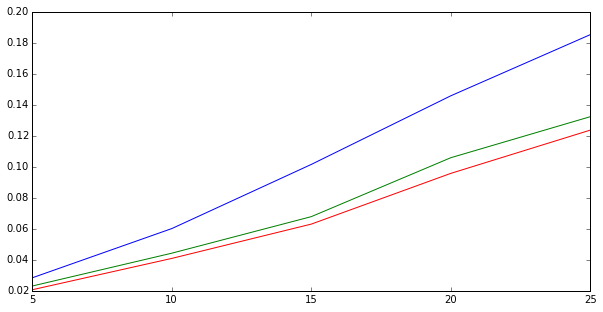

In [82]:


radius = roll_width

keypoint_radius = 11
keypoint_orientation_bins = 19
keypoint_peak_factor = 0.8

feature_radius = 20
feature_orientation_bins = 12
feature_inner_radius_factor = 0.5
feature_sigma_divisor = 1.

skip = 5
start = 1000

stats = []
num_brackets = 3
bracket_factor = 5.


# for keypoint_radius in range(5, 31):
#     var = keypoint_radius

# for keypoint_peak_factor in np.linspace(0.5, 1.0, num=11):
#     var = keypoint_peak_factor

# for keypoint_orientation_bins in range(10, 31):
#     var = keypoint_orientation_bins

# for feature_radius in range(5, 31):
#     var = feature_radius

# for feature_orientation_bins in range(5, 31):
#     var = feature_orientation_bins

# for feature_inner_radius_factor in np.linspace(0.2, .75, num=12):
#     var = feature_inner_radius_factor

# for feature_sigma_divisor in np.linspace(0.5, 2., num=7):
#     var = feature_sigma_divisor

for skip in range(5,26, 5):
    var = skip

# for start in range(1000, 1050, 5):
#     var = start
    
    print var
    
    start_time = time.time()
    
    dist_non_matches = np.zeros(num_brackets)
    totalkeypoints = 0.

    for t1 in range(start, 1999, 50):

        t2 = t1+skip

        allFeatures = []

        for idx in [t1, t2]:

            of, keypoints, bmp = loadData(idx)
        #     of, keypoints, bmp = loadData_Lyap(idx)

            # Generate additional keypoints based on orientation fields.
            allkeypoints = assignOrientations(keypoints, keypoint_radius, of, keypoint_orientation_bins, keypoint_peak_factor, bmp, 0)            
            
            # Loop through all keypoints and generate feature vectors
            for i in range(allkeypoints.shape[0]):

                x = allkeypoints[i,0]
                y = allkeypoints[i,1]

                orientation = allkeypoints[i,8]
                rotation = -orientation*(180./keypoint_orientation_bins)

                # Only process points within tolerance of boundary
                if (((x - centerx)**2 + (y - centery)**2) <= crop_radius**2):
                    features = np.concatenate(([idx], allkeypoints[i], [bmp[y, x]], getFeatureVector(of, rotation, x, y, feature_radius, feature_inner_radius_factor, feature_orientation_bins, feature_sigma_divisor, bmp, 0)),axis=0)
                    if len(allFeatures) == 0:
                        allFeatures = features
                    else:
                        allFeatures = np.vstack([allFeatures, features])


        features1 = allFeatures[(allFeatures[:,0] == t1)]
        features2 = allFeatures[(allFeatures[:,0] == t2)]

        totalkeypoints = totalkeypoints + features1.shape[0]

        distance_stats = []

        # Loop through each keypoint in the first image
        for i in range(features1.shape[0]):

            location = np.asarray(features1[i,1:3])

#             # Get the features that are within the radius of the locations
#             k2 = spatial.KDTree(features2[:, 1:3])

#             # Get 50 nearest neighbors within radius
#             nn2 = k2.query(location, k=50, distance_upper_bound=roll_width)

#             # Remove infinite matches
#             nn2 = nn2[1]
#             nn2 = nn2[(nn2<features2.shape[0])]

            f1 = features1[i]
#             f2 = features2[nn2]
            f2 = features2

            # Get the Euclidean distance to the location corresponding to the nearest neighbor keypoint in feature space
            if f2.shape[0] > 0:
                dist = computeDistance(f1, f2)

            if i == 0:
                distance_stats = np.hstack(([f1[0]],f1[3:9], dist))
            else:
                distance_stats = np.vstack((distance_stats, np.hstack(([f1[0]],f1[3:9], dist))))

        non_matches = np.zeros(num_brackets)
        tmp_non_matches = distance_stats[(distance_stats[:,-1] >= bracket_factor)]
        for n in range(num_brackets):
            non_matches[n] = tmp_non_matches.shape[0]
            if (n+1)<num_brackets:
                tmp_non_matches = tmp_non_matches[(tmp_non_matches[:,-1] >= bracket_factor*(n+2))]
        dist_non_matches = dist_non_matches + non_matches

    percent_not_matched = dist_non_matches/totalkeypoints
    
    print totalkeypoints
    
    if len(stats) == 0:
        stats = np.hstack(([var], percent_not_matched))
    else:
        stats = np.vstack((stats, np.hstack(([var], percent_not_matched))))
        
    print("--- %s seconds ---" % (time.time() - start_time))

for n in range(num_brackets):
    plt.plot(stats[:,0], stats[:,n+1])


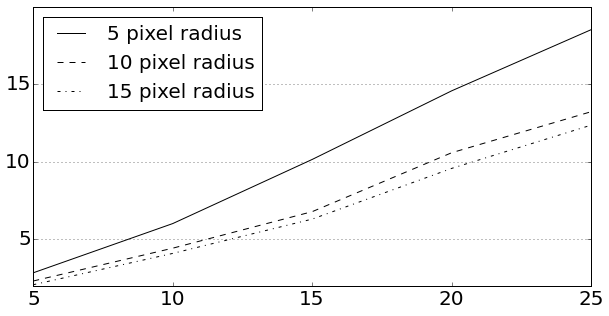

In [86]:
lines=['-', '--', '-.']

for n in range(num_brackets):
    plt.plot(stats[:,0], stats[:,n+1]*100, color='black', linestyle=lines[n]);
plt.legend(['5 pixel radius', '10 pixel radius', '15 pixel radius'], loc=2, fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20);
plt.tick_params(axis='both', which='minor', labelsize=20);
plt.yticks(np.arange(math.floor(min(stats[:,n+1]*100))+3, math.ceil(max(stats[:,n+1]*100))+5, 5));
ax = plt.axes()  
ax.yaxis.grid() # horizontal lines

In [41]:
stats_average = np.average(stats, axis=0)[1:]

for n in range(num_brackets):
    plt.plot(stats[:,0], stats[:,n+1])
    plt.plot([1000, 1045], [stats_average[n], stats_average[n]], '--')
    


/Users/birdbrain/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


IndexError: invalid index to scalar variable.

# Generate the features!

In [23]:

radius = roll_width

keypoint_radius = 11
keypoint_orientation_bins = 19
keypoint_peak_factor = 0.8

feature_radius = 20
feature_orientation_bins = 12
feature_inner_radius_factor = 0.5
feature_sigma_divisor = 1.


for idx in range(1000, 1001):

    allFeatures = []


    of, keypoints, bmp = loadData(idx)
#     of, keypoints, bmp = loadData_Lyap(idx)
    
    orientation_col = keypoints.shape[1]

    # Generate additional keypoints based on orientation fields.
    allkeypoints = assignOrientations(keypoints, keypoint_radius, of, keypoint_orientation_bins, keypoint_peak_factor, bmp, 0)            

    # Loop through all topological and p.h. defects and generate feature vectors
    for i in range(allkeypoints.shape[0]):

        x = allkeypoints[i,0]
        y = allkeypoints[i,1]

        orientation = allkeypoints[i,orientation_col]
        rotation = -orientation*(180./keypoint_orientation_bins)

        # Only process points within tolerance of boundary
        if (((x - centerx)**2 + (y - centery)**2) <= crop_radius**2):
            features = np.concatenate(([idx], allkeypoints[i], [bmp[y, x]], getFeatureVector(of, rotation, x, y, feature_radius, feature_inner_radius_factor, feature_orientation_bins, feature_sigma_divisor, bmp, 0)),axis=0)
            if len(allFeatures) == 0:
                allFeatures = features
            else:
                allFeatures = np.vstack([allFeatures, features])

    # Save feature vectors to file
    if len(allFeatures.shape)==1:
        sOut = ' '.join([str(x) for x in allFeatures.tolist()])
        with open(sDir + '/' + (sFeatureVectors % idx), 'w') as f:
            f.write(sOut)
    else:
        np.savetxt(sDir + '/' + (sFeatureVectors % idx),allFeatures,fmt='%d',delimiter=' ')




[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[[  9 110]]


In [112]:
idx = 1000

nbins_local = 8

of, keypoints, bmp = loadData(idx)

# Generate additional keypoints based on orientation fields.
allkeypoints = assignOrientations(keypoints, radius, of, 18)

allFeatures = []

# Loop through all topological and p.h. defects and generate feature vectors
for i in range(keypoints.shape[0]):

    x = keypoints[i,0]
    y = keypoints[i,1]
    
    orientation = allkeypoints[i,8]
    rotation = -orientation*10

    # Only process points within tolerance of boundary
    if (((x - centerx)**2 + (y - centery)**2) <= crop_radius**2):
        features = np.concatenate((allkeypoints[i], [bmp[y,x]], getFeatureVector(of, rotation, x, y, radius/2, nbins_local)),axis=0)
        if len(allFeatures) == 0:
            allFeatures = features
        else:
            allFeatures = np.vstack([allFeatures, features])


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(bmp)
plt.scatter(allFeatures[:,0], allFeatures[:,1], color='black')

In [10]:
tmp_radius = radius

key = allFeatures[10,:]
 
orientation = key[8]
rotation = -orientation*10

key_bmp = bmp[(key[1]-tmp_radius):(key[1]+tmp_radius), (key[0]-tmp_radius):(key[0]+tmp_radius)]
key_of = of[(key[1]-tmp_radius):(key[1]+tmp_radius), (key[0]-tmp_radius):(key[0]+tmp_radius)]

print key
print orientation, rotation

[136 204   1   0   0   0   0   0   6 145  86   4   8   6   4   0   0   0
   0   5   2   2   3  10   0   0   0   1   1   3  13   4   0   0   0   1
  13   7   1   0   0   0   0  30   3   0   3  11   0   0   0  15   0   0
   0  28   2   1   1   8   0   0   1  36   0   1   1  27   7   3   7   3
   0   0   0]
6 -60


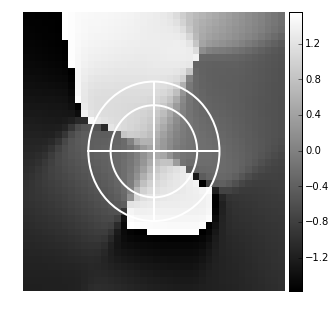

In [11]:
transform_key_of = (math.pi*key_of/255.)-math.pi/2.

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.figure()
ax = plt.gca()
plt.set_cmap('gray')
plt.gca().set_axis_off()
# im = ax.pcolor(key_bmp);
im = ax.pcolor(transform_key_of);

plt.plot([tmp_radius - tmp_radius/2., tmp_radius + tmp_radius/2.], [tmp_radius, tmp_radius], color='white', lw=2)
plt.plot([tmp_radius, tmp_radius], [tmp_radius - tmp_radius/2., tmp_radius + tmp_radius/2.], color='white', lw=2)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

circle1 = plt.Circle((tmp_radius, tmp_radius), tmp_radius/2., color='white', fill=False, lw=2)
ax.add_artist(circle1)

circle2 = plt.Circle((tmp_radius, tmp_radius), 0.66*tmp_radius/2., color='white', fill=False, lw=2)
ax.add_artist(circle2)


plt.scatter(tmp_radius, tmp_radius, color='black')



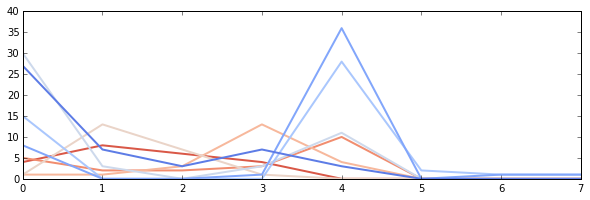

In [12]:

plt.rcParams['figure.figsize'] = (10.0, 3.0)
fig = plt.gcf()
ax = plt.gca()
ax.set_color_cycle(sns.color_palette("coolwarm_r",8))
plt.plot(np.reshape(key[11:], (8,nbins_local)).T, lw=2);



In [14]:
inner_radius = int(radius*0.66)
outer_radius = radius
orientationfield = of
nbins = 8

x = key[0]
y = key[1]

orientation = key[8]
rotation = -orientation*10

print rotation

# INNER CIRCLE
# Get circular crop
crop = np.zeros((inner_radius*2, inner_radius*2))
crop[inner_radius, inner_radius] = 1
crop = morphology.binary_dilation(crop, morphology.disk(inner_radius))

# Crop orientation field
cropped_orientation = orientationfield[(y-inner_radius):(y+inner_radius), (x-inner_radius):(x+inner_radius)]


# Rotate cropped orientation field
rotated_orientation = ((cropped_orientation.astype(np.float)*(180./255.) + float(rotation))*(255./180.)).astype(np.int)%255



-60


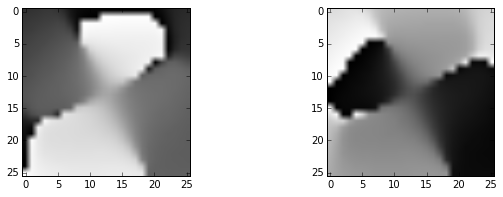

In [15]:
plt.subplot(1,2,1)
plt.imshow(cropped_orientation);
plt.subplot(1,2,2)
plt.imshow(rotated_orientation);

[165 260   1   0   0   0   0   0]


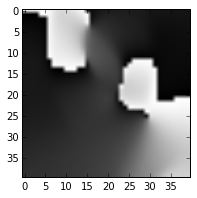

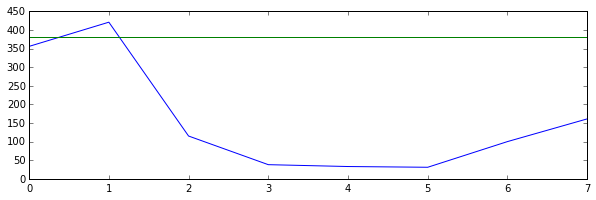

In [16]:
idx = 1000

nbins_local = 8

of, keypoints, bmp = loadData(idx)

key = keypoints[4,:]
print key

# Get circular crop
crop = np.zeros((radius*2, radius*2))
crop[radius, radius] = 1
crop = morphology.binary_dilation(crop, morphology.disk(radius))

x = key[0]
y = key[1]


# Crop orientation field
cropped_orientation = of[(y-radius):(y+radius), (x-radius):(x+radius)]

plt.figure()
plt.imshow(cropped_orientation)

# Get histogram for the orientation field
hist = np.histogram(cropped_orientation[crop==1], bins=nbins, range=(0,256))[0]

plt.figure()
plt.plot(hist)

# Smooth the histogram slightly
hist = gaussian_filter(hist, sigma=0.5)
maxpeak = max(hist)

plt.plot([0,7], [maxpeak, maxpeak])

peaks = (hist >= 0.8*float(maxpeak)).astype(np.int)
peak_components = measure.label(peaks, background=0)+1
